In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_hex
from matplotlib.ticker import FixedLocator
from plot_config import PlotConfig
import json
import bgp_qnm_fits as bgp
import seaborn as sns
import os 
import corner
from matplotlib.lines import Line2D

In [ ]:
sim_id = "0010"
DATA_TYPE = 'news'
t0 = 50 
T = 100
INCLUDE_CHIF = False
INCLUDE_MF = False

modes = [(2,2,0,1), (3,3,0,1), (3,3,1,1)] 
sph_modes = [(2,2), (3,3)]

PLT_modes = [(2,2), (3,3)]

sim = bgp.SXS_CCE(sim_id, type=DATA_TYPE, lev="Lev5", radius="R2")
tuned_param_dict_GP = bgp.get_tuned_param_dict("GP", data_type=DATA_TYPE)[sim_id]

/data/vault/rvnd2/Code/qnmfits/qnmfits/Waveforms/Base.py:116: RuntimeWarning: divide by zero encountered in divide
  chidot = self.Jdot/(self.Moft**2).reshape(len(self.Moft),1)


In [3]:
sim_data_artificial = {mode: sim.h[mode] for mode in sim.h}

In [4]:
A_PLT_real = 0.0015
A_PLT_imag = 0.0025

t_PLT = 16
lam_PLT = 1.8

threshold = 30
PLT_term = np.where(sim.times > threshold, (A_PLT_real + 1j * A_PLT_imag) * ((sim.times - t_PLT)/(t0 - t_PLT)) ** (-lam_PLT), 0)
#PLT_term = (A_PLT_real + 1j * A_PLT_imag) * ((sim.times - t_PLT)/(t0 - t_PLT)) ** (-lam_PLT)

sim_data_artificial[(2,2)] = sim.h[(2,2)] + PLT_term

/tmp/ipykernel_42258/2623925680.py:8: RuntimeWarning: invalid value encountered in power
  PLT_term = np.where(sim.times > threshold, (A_PLT_real + 1j * A_PLT_imag) * ((sim.times - t_PLT)/(t0 - t_PLT)) ** (-lam_PLT), 0)


The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


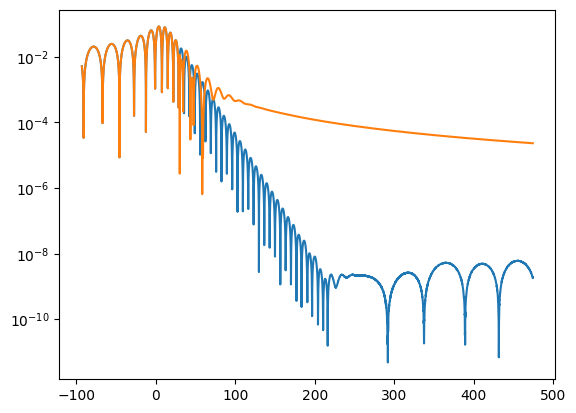

In [5]:
plt.plot(sim.times, np.abs(sim.h[(2,2)].imag), label='Original (2,2)')
plt.plot(sim.times, np.abs(sim_data_artificial[(2,2)].imag), label='With PLT (2,2)')
#plt.plot(sim.times, np.abs(sim_data_artificial[(2,2)].real - sim.h[(2,2)].real), label='PLT Term (2,2)')
plt.yscale('log')

In [6]:
A_PLT_real_2 = 0.0023
A_PLT_imag_2 = 0.0024

t_PLT_2 = 14
lam_PLT_2 = 1.2

threshold = 30
PLT_term = np.where(sim.times > threshold, (A_PLT_real_2 + 1j * A_PLT_imag_2) * ((sim.times - t_PLT_2)/(t0 - t_PLT_2)) ** (-lam_PLT_2), 0)
#PLT_term = (A_PLT_real + 1j * A_PLT_imag) * ((sim.times - t_PLT)/(t0 - t_PLT)) ** (-lam_PLT_2)

sim_data_artificial[(3,3)] = sim.h[(3,3)] + PLT_term

/tmp/ipykernel_42258/1089344339.py:8: RuntimeWarning: invalid value encountered in power
  PLT_term = np.where(sim.times > threshold, (A_PLT_real_2 + 1j * A_PLT_imag_2) * ((sim.times - t_PLT_2)/(t0 - t_PLT_2)) ** (-lam_PLT_2), 0)


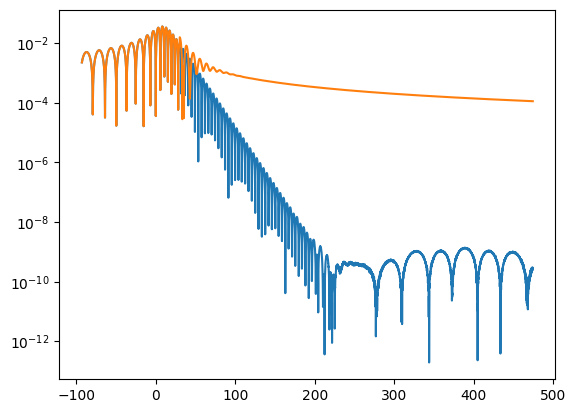

In [7]:
plt.plot(sim.times, np.abs(sim.h[(3,3)].imag), label='Original (3,3)')
plt.plot(sim.times, np.abs(sim_data_artificial[(3,3)].imag), label='With PLT (3,3)')
#plt.plot(sim.times, np.abs(sim_data_artificial[(3,3)].real - sim.h[(3,3)].real), label='PLT Term (3,3)')
plt.yscale('log')

In [9]:
fit = bgp.PLT_BGP_fit(
    sim.times,
    sim_data_artificial,
    modes,
    sim.Mf,
    sim.chif_mag,
    tuned_param_dict_GP,
    bgp.kernel_GP,
    t0=t0,
    PLT_modes=PLT_modes,
    lam_PLT_val = [lam_PLT, lam_PLT_2],
    nsteps=1000,
    nwalkers=20,
    T=T,
    spherical_modes=sph_modes,
    include_chif=INCLUDE_CHIF,
    include_Mf=INCLUDE_MF,
    data_type=DATA_TYPE
)

100%|██████████| 1000/1000 [02:44<00:00,  6.09it/s]


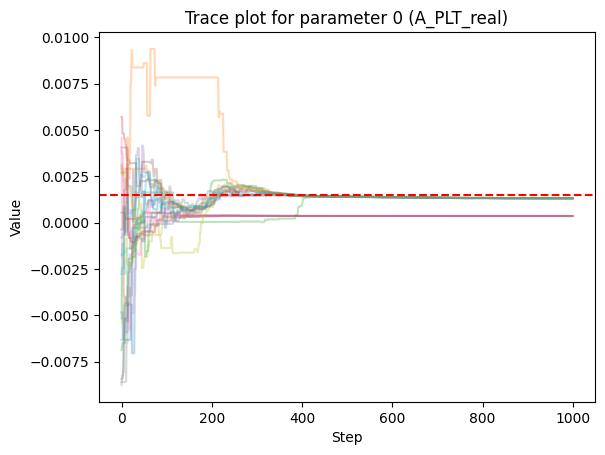

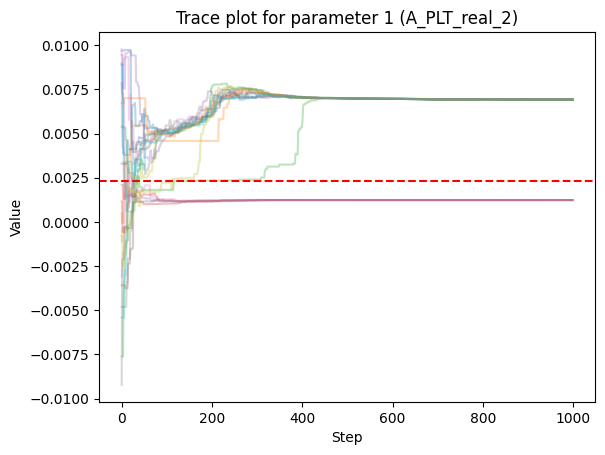

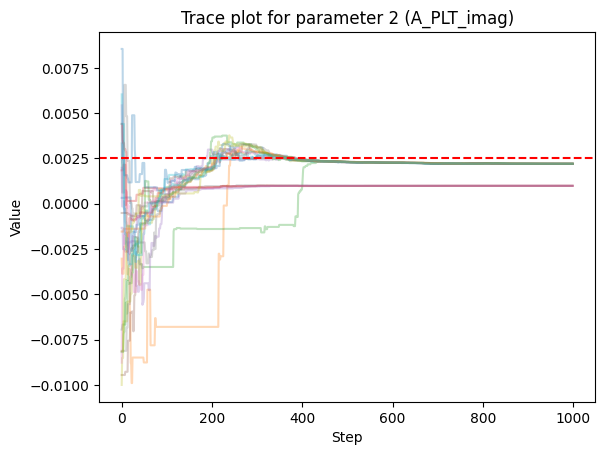

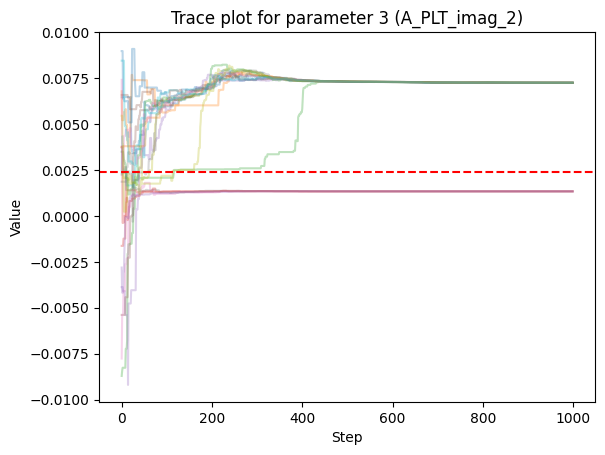

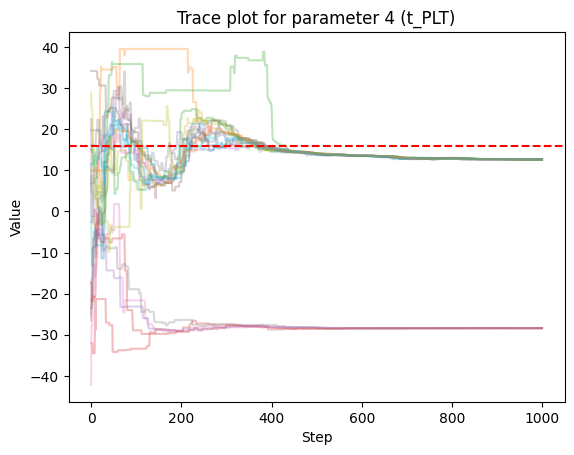

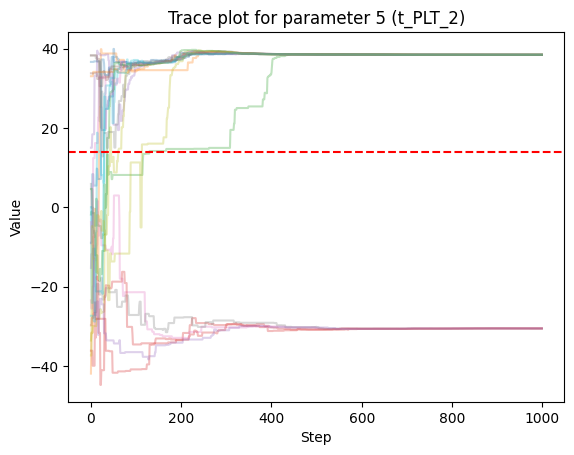

In [10]:
# mcmc_samples: shape (nsteps, nwalkers, ndim)
samples = fit.sampler.get_chain()  # shape: (nsteps, nwalkers, ndim)
param_names = ["A_PLT_real", "A_PLT_real_2", "A_PLT_imag", "A_PLT_imag_2", "t_PLT", "t_PLT_2"]   # Adjust as needed
true_values = [A_PLT_real, A_PLT_real_2, A_PLT_imag, A_PLT_imag_2, t_PLT, t_PLT_2]  # True values for reference

for i in range(len(param_names)):
    plt.figure()
    for walker in range(samples.shape[1]):
        plt.plot(samples[:, walker, i], alpha=0.3)
    plt.axhline(true_values[i], color='red', linestyle='--', label='True value')
    plt.title(f"Trace plot for parameter {i} ({param_names[i]})")
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.show()

burn_in = int(0.5 * samples.shape[0])
flat_samples = fit.sampler.get_chain(discard=burn_in, flat=True)  


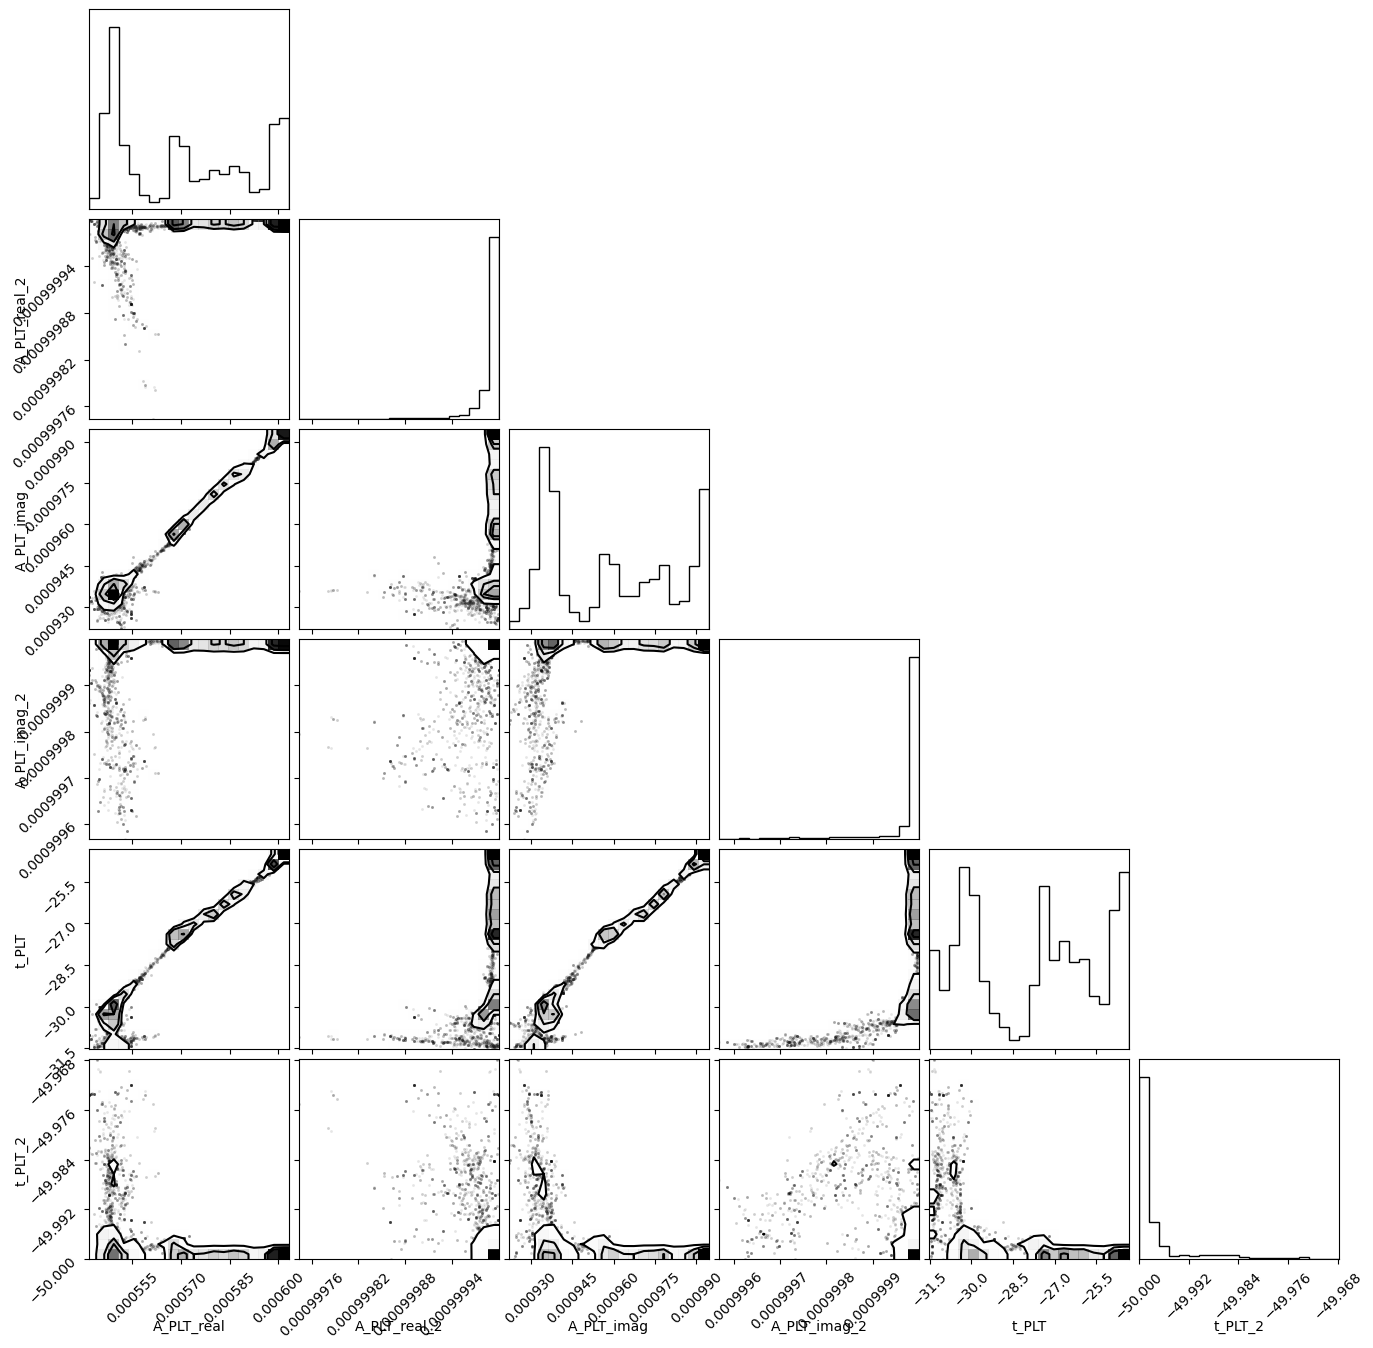

In [ ]:
corner.corner(flat_samples, labels=param_names)
plt.show()